In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
! pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.3 MB/s eta 0:00:00


In [3]:
data = pd.read_csv('/kaggle/input/eurusd/EURUSD-30-DS.csv', header=None, names=['Date','Open', 'High', 'Low', 'Close','Volume'])
data.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45770,1.45937,6473.2500
1,01.01.2008 02:30:00.000,1.45965,1.45982,1.45768,1.45785,6484.6000
2,01.01.2008 03:00:00.000,1.45788,1.45803,1.45761,1.45784,4957.6000
3,01.01.2008 03:30:00.000,1.45788,1.45794,1.45754,1.45770,3416.5500
4,01.01.2008 04:00:00.000,1.45770,1.45983,1.45766,1.45954,5553.4375


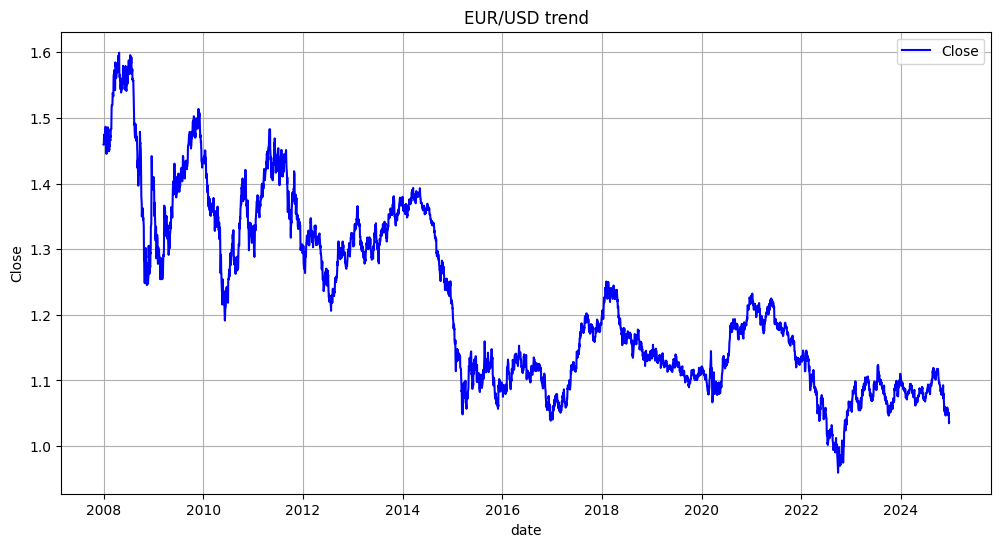

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S.%f')
df['Day'] = df['Date'].dt.date
daily_data = df.groupby('Day').first().reset_index()  # اولین نمونه هر روز

# 4. رسم Line Plot برای Close
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Date'], daily_data['Close'], label='Close', color='blue')

# 5. تنظیمات نمودار
plt.title('EUR/USD trend')
plt.xlabel('date')
plt.ylabel('Close')
plt.legend()
plt.grid(True)

# 6. نمایش
plt.show()

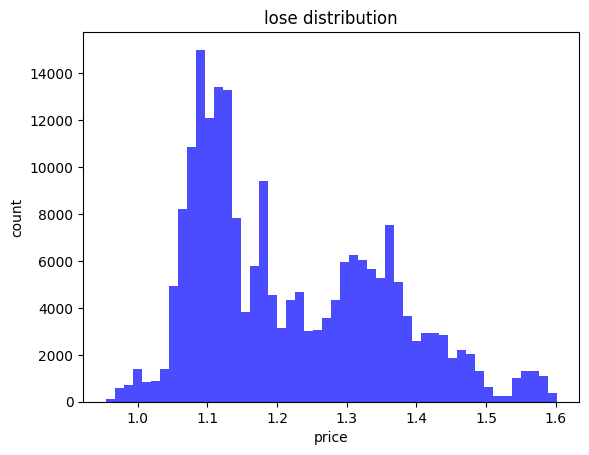

In [5]:
plt.hist(df['Close'], bins=50, color='blue', alpha=0.7)
plt.title('lose distribution')
plt.xlabel('price')
plt.ylabel('count')
plt.show()

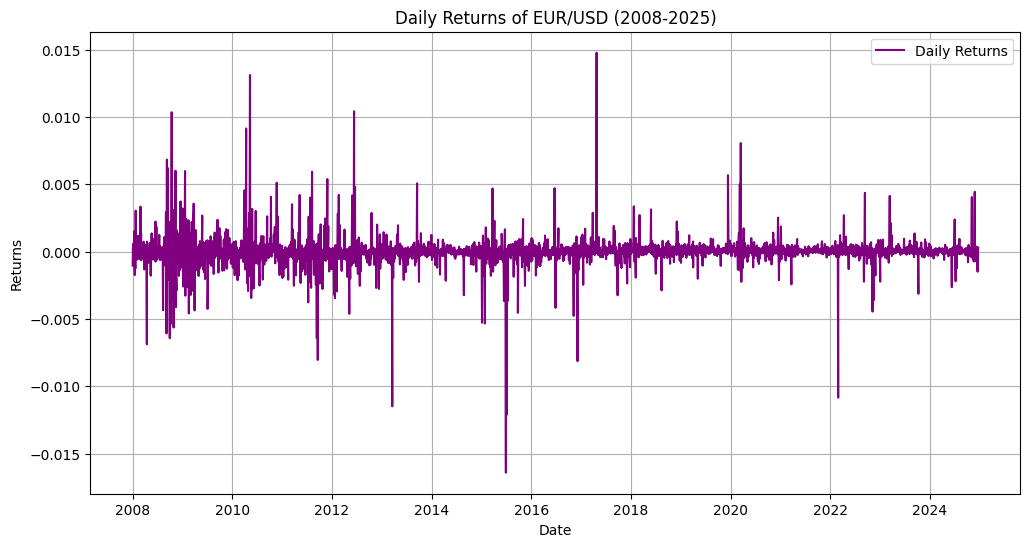

In [6]:
# Ensure 'Returns' is calculated only if not already present
if 'Returns' not in df.columns:
    df['Returns'] = df['Close'].pct_change()

if 'Returns' not in daily_data.columns:
    daily_data['Returns'] = daily_data['Close'].pct_change()

# Plotting daily returns
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Day'], daily_data['Returns'], label='Daily Returns', color='purple')
plt.title('Daily Returns of EUR/USD (2008-2025)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

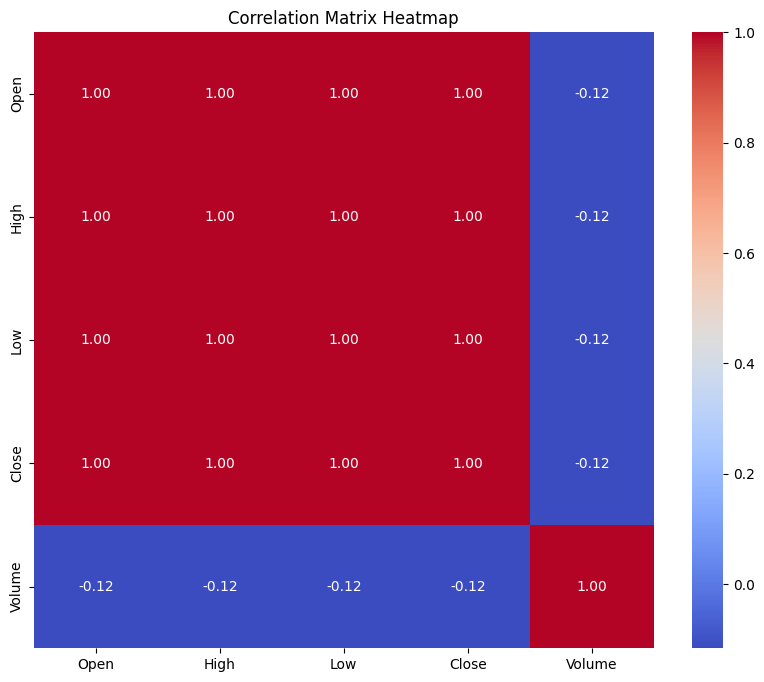

In [7]:
import seaborn as sns
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [8]:
input_features = ['Close', 'Volume']
scalers_inputs = {col: MinMaxScaler() for col in input_features}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in input_features])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['Open', 'High', 'Low', 'Close']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))

In [9]:
def create_sequences(inputs, outputs, seq_length):
    X, y = [], []
    for i in range(len(inputs) - seq_length):
        X.append(inputs[i:i + seq_length])
        y.append(outputs[i + seq_length])  # 4 مقدار OHLC تایم‌فریم بعدی
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length)

In [10]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 169488
تعداد نمونه‌های Validation: 21186
تعداد نمونه‌های Test: 21187


In [11]:
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(60, len(input_features))))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(25, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(4))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=128, 
                    validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0144 - mae: 0.0745 - val_loss: 1.2325e-04 - val_mae: 0.0101
Epoch 2/50
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0014 - mae: 0.0250 - val_loss: 4.6323e-04 - val_mae: 0.0196
Epoch 3/50
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 8.9637e-04 - mae: 0.0211 - val_loss: 0.0010 - val_mae: 0.0295
Epoch 4/50
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 8.3115e-04 - mae: 0.0204 - val_loss: 1.0936e-04 - val_mae: 0.0100
Epoch 5/50
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 8.0401e-04 - mae: 0.0201 - val_loss: 2.1311e-05 - val_mae: 0.0034
Epoch 6/50
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 8.1616e-04 - mae: 0.0202 - val_loss: 3.2925e-05 - val_mae: 0.0047
Epoch 7/50
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 8.0695e-04 - mae: 0.0200 - val_loss: 1.2293e-05 - val_mae: 0.0025
Epoch 8/50
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 7.9269e-04 - mae: 0.0199 - val_loss: 4

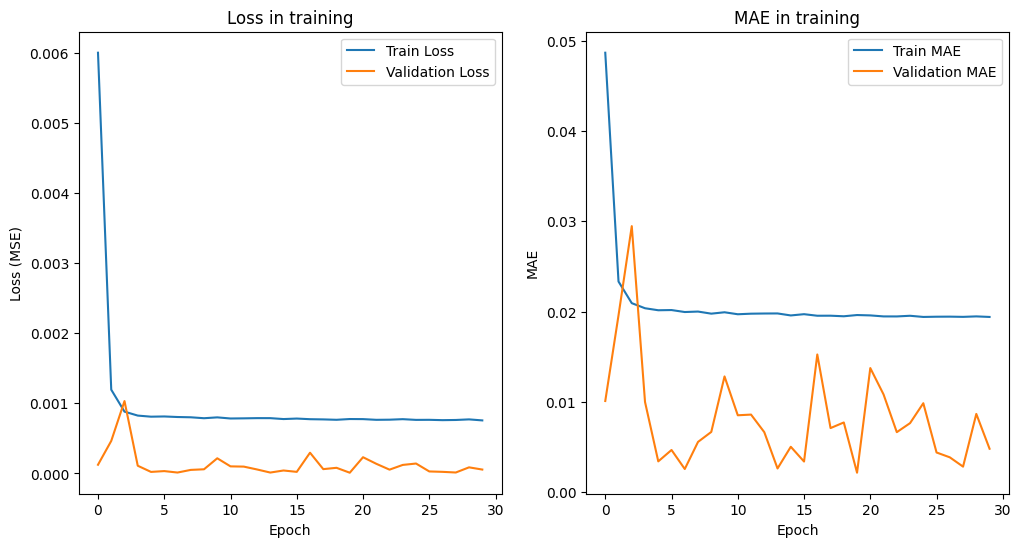

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

663/663 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

معیارهای ارزیابی برای Open:
MSE: 1.6428550030189283e-06
RMSE: 0.001281739054183389
MAE: 0.0009103135324151276
R² Score: 0.9941793315427727

معیارهای ارزیابی برای High:
MSE: 2.0032672882135453e-06
RMSE: 0.0014153682518035881
MAE: 0.0010644651459254457
R² Score: 0.9928873342198601

معیارهای ارزیابی برای Low:
MSE: 1.797239441266691e-06
RMSE: 0.0013406115922468711
MAE: 0.0009093819293263736
R² Score: 0.993642398933855

معیارهای ارزیابی برای Close:
MSE: 2.0089599837547207e-06
RMSE: 0.001417377854968364
MAE: 0.0009979646500421686
R² Score: 0.9928841001592837

دقت جهت برای Close: 48.17804210327575%


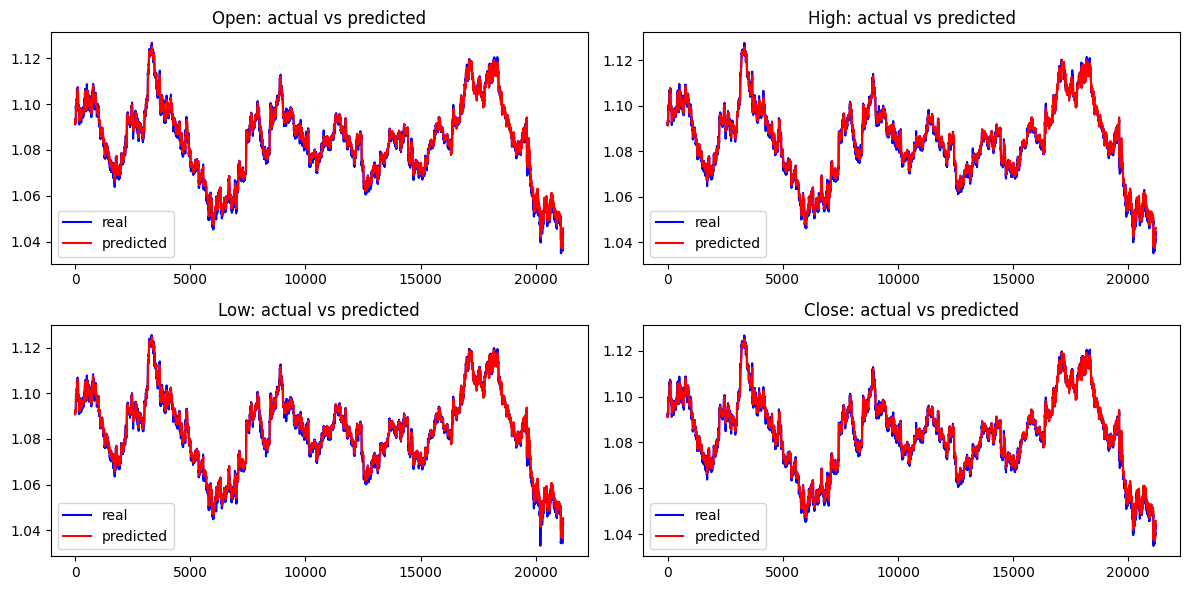

In [14]:
# 9. پیش‌بینی
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_open = scalers_outputs['Open'].inverse_transform(predictions[:, 0].reshape(-1, 1))
predictions_high = scalers_outputs['High'].inverse_transform(predictions[:, 1].reshape(-1, 1))
predictions_low = scalers_outputs['Low'].inverse_transform(predictions[:, 2].reshape(-1, 1))
predictions_close = scalers_outputs['Close'].inverse_transform(predictions[:, 3].reshape(-1, 1))

y_test_open = scalers_outputs['Open'].inverse_transform(y_test[:, 0].reshape(-1, 1))
y_test_high = scalers_outputs['High'].inverse_transform(y_test[:, 1].reshape(-1, 1))
y_test_low = scalers_outputs['Low'].inverse_transform(y_test[:, 2].reshape(-1, 1))
y_test_close = scalers_outputs['Close'].inverse_transform(y_test[:, 3].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_open, predictions_open, "Open")
calculate_metrics(y_test_high, predictions_high, "High")
calculate_metrics(y_test_low, predictions_low, "Low")
calculate_metrics(y_test_close, predictions_close, "Close")

# 12. دقت جهت برای Close
correct_directions = np.sum(np.sign(predictions_close[1:] - predictions_close[:-1]) == np.sign(y_test_close[1:] - y_test_close[:-1]))
directional_accuracy = correct_directions / (len(predictions_close) - 1)
print(f"\nدقت جهت برای Close: {directional_accuracy * 100}%")

# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(y_test_open, label='real', color='blue')
plt.plot(predictions_open, label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high, label='real', color='blue')
plt.plot(predictions_high, label='predicted', color='red')
plt.title('High: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low, label='real', color='blue')
plt.plot(predictions_low, label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close, label='real', color='blue')
plt.plot(predictions_close, label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.legend()

plt.tight_layout()
plt.show()

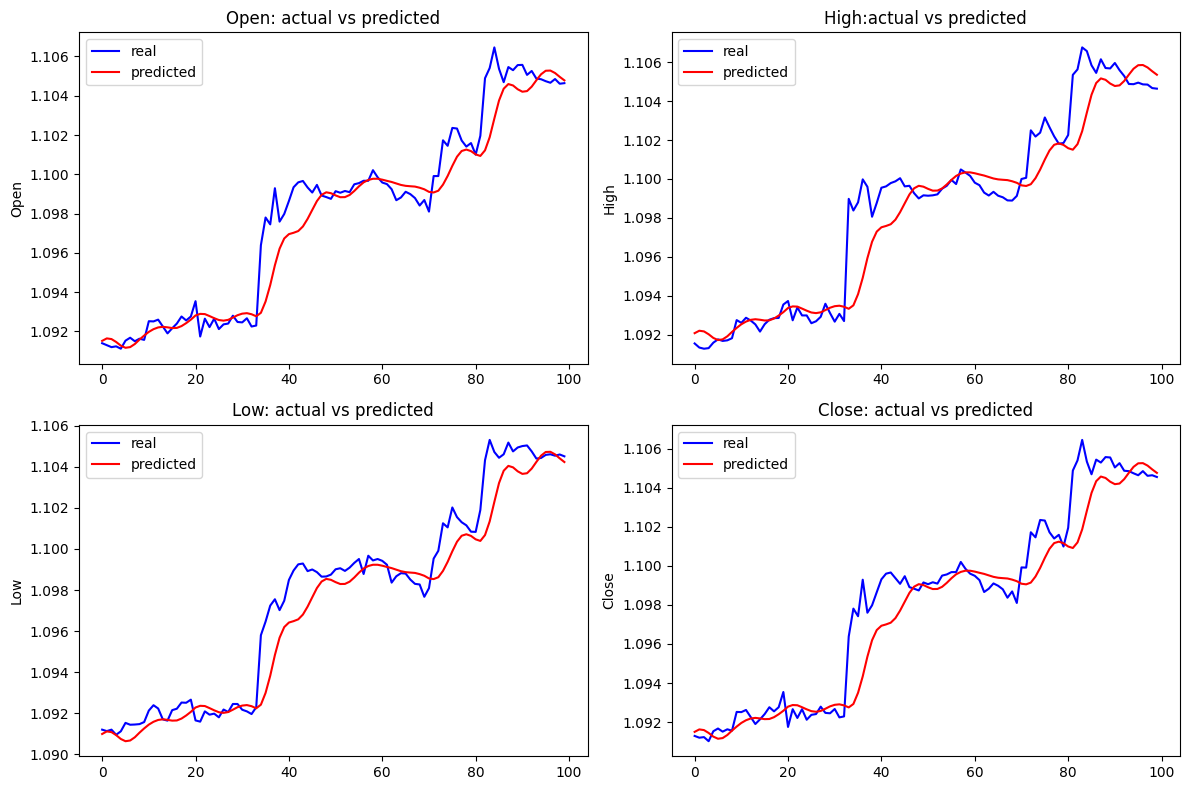

In [15]:
n_samples = 100  # تعداد نمونه‌هایی که می‌خوای نشون بدی

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(y_test_open[:n_samples], label='real', color='blue')
plt.plot(predictions_open[:n_samples], label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.ylabel('Open')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high[:n_samples], label='real', color='blue')
plt.plot(predictions_high[:n_samples], label='predicted', color='red')
plt.title('High:actual vs predicted')
plt.ylabel('High')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low[:n_samples], label='real', color='blue')
plt.plot(predictions_low[:n_samples], label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.ylabel('Low')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close[:n_samples], label='real', color='blue')
plt.plot(predictions_close[:n_samples], label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.ylabel('Close')
plt.legend()

plt.tight_layout()
plt.show()